/home/julian/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


UMPM
load frame  0
load frame  60
load frame  120
load frame  180
load frame  240
elapsed 30.578994512557983


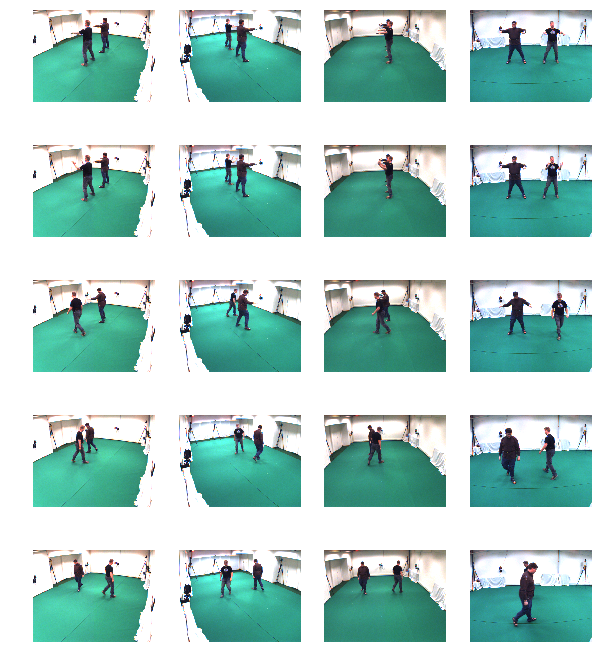

In [1]:
%matplotlib inline
# ---- settings ----
import json
Settings = json.load(open('../settings.txt'))
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sys
sys.path.insert(0, '../'); sys.path.insert(0, '.')
import paf_loader
from os.path import join, isdir
import numpy as np
import cv2
from cselect import color as cs
from time import time

from mvpose.data import umpm

root = join(Settings['data_root'], 'pak')
user = Settings['UMPM']['username']
pwd = Settings['UMPM']['password']
tmp = Settings['tmp']

_start = time()
X, Y, Calib = umpm.get(root, 'p2_free_1', user, pwd)

# **************************** #
FRAMES = [0, 60, 120, 180, 240]
# **************************** #

def get_track(FRAMES):
    Ims = []
    Hms = []
    Pafs = []
    for frame in FRAMES:
        print('load frame ', frame)
        Im = np.array([X[0][frame], X[1][frame], X[2][frame], X[3][frame]])
        Ims.append(Im)
        heatmaps, pafs = paf_loader.load_confidence_map_and_paf('umpm', 
                                                            Im, 
                                                            frame, 
                                                            dir=tmp)
        Hms.append(heatmaps)
        Pafs.append(pafs)

    Ims = np.array(Ims)
    Hms = np.array(Hms)
    Pafs = np.array(Pafs)
    return Ims, Hms, Pafs

Ims, Hms, Pafs = get_track(FRAMES)
_end = time()
print('elapsed', _end - _start)

fig = plt.figure(figsize=(10,12))
n = len(FRAMES)
for frame, Im in enumerate(Ims):
    for cid in range(4):
        ax = fig.add_subplot(n, 4, frame*4+cid+1)
        ax.axis('off')
        ax.imshow(Im[cid])

plt.show()

calib 5
hm 5
paf 5
handling frame  0
	step 1: elapsed 1.2868585586547852
	step 2: elapsed 0.015735864639282227
step 3: elapsed 0.1010129451751709
handling frame  1
	step 1: elapsed 1.2343027591705322
	step 2: elapsed 0.015818119049072266
step 3: elapsed 0.10244536399841309
handling frame  2
	step 1: elapsed 1.2208054065704346
	step 2: elapsed 0.014665842056274414
step 3: elapsed 0.11318087577819824
handling frame  3
	step 1: elapsed 1.2270712852478027
	step 2: elapsed 0.017168521881103516
step 3: elapsed 0.14133095741271973
handling frame  4
	step 1: elapsed 1.2233331203460693
	step 2: elapsed 0.01652216911315918
step 3: elapsed 0.08800983428955078
elapsed 6.8218677043914795


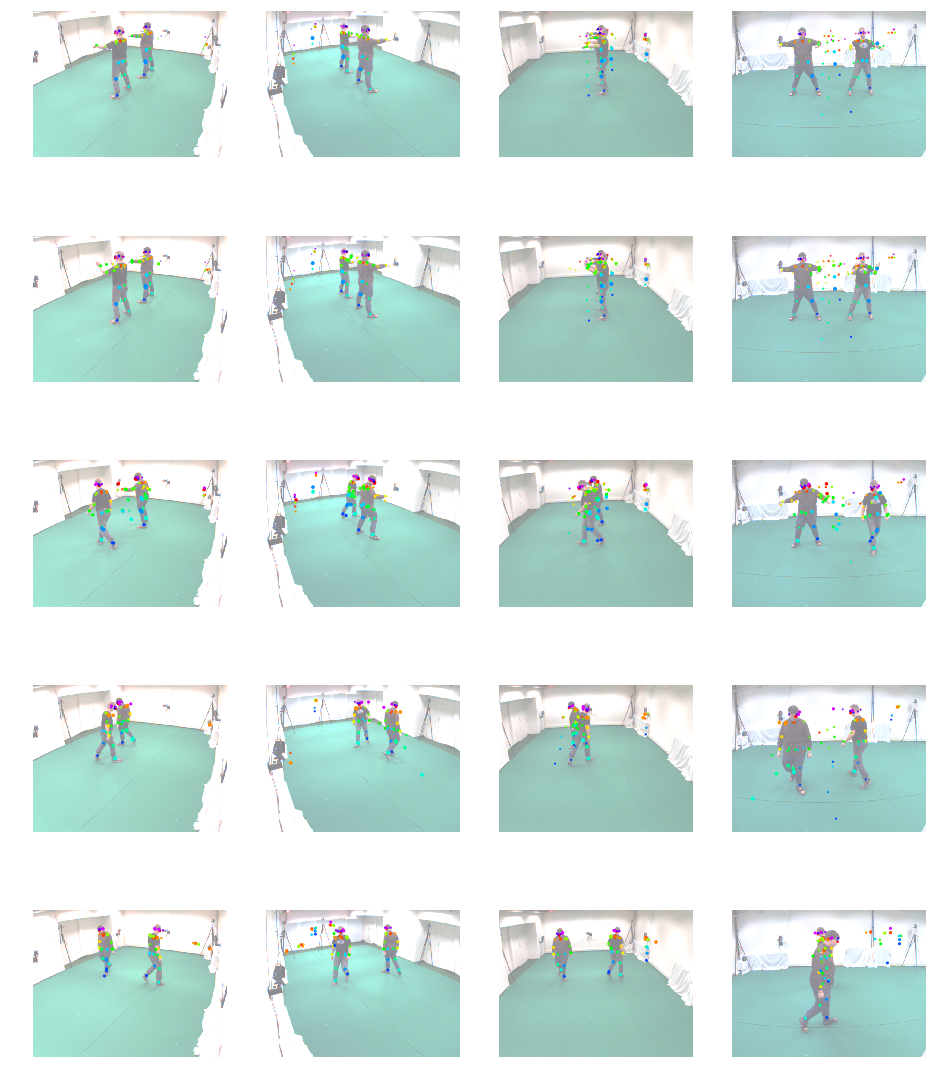

In [4]:
from mvpose.tracking import track

# =============================
_start = time()
Debug = track([Calib], Hms, Pafs, debug=True)
_end = time()
print('elapsed', _end - _start)
# =============================

n_frames = Debug.n_frames
n_joints = Debug.candidates[0].n_joints

colors = cs.lincolor(22)/255

fig = plt.figure(figsize=(16,20))

_ct = 1
for frame, Im in enumerate(Ims):
    for cid, cam in enumerate(Calib):
        h,w,_ = Im[cid].shape
        ax = fig.add_subplot(n_frames, 4, _ct); ax.axis('off')
        ax.set_xlim([0, w])
        ax.set_ylim([h, 0])
        _ct += 1; ax.imshow(Im[cid], alpha=0.5)
        
        for jid in range(n_joints):
            centers3d_with_w = Debug.meanshifts[frame].centers3d[jid]
            centers3d = centers3d_with_w[:,0:3].astype('float32')
            centers2d = cam.projectPoints(centers3d)
            score = centers3d_with_w[:,3]
            for p2d in centers2d:
                if p2d is not None:
                    x, y = p2d
                    ax.scatter(x, y, color=colors[jid], s=score*1)
        

plt.show()